# 3. ELAIS-N1 Luminosity Function with SERVS only

In order to test the more sophisticated selection function methods we will first try producing an LF from the SERVS region only since we can use the completeness curve from their simulations and use to results to compare using regions of differing depths.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100) [with local modifications]
This notebook was executed on: 
2018-10-04 13:22:16.287191


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
Lsun= const.L_sun.value

import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

In [3]:
#os.environ['GAMA_DATA'] = 'We are not using GAMA data'
#from luminosity_function.gal_sample import CosmoLookup

In [26]:
FIELD = 'ELAIS-N1'
#FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"
#DMU_DIR = '/mnt/hedam/dmu_products/'
DMU_DIR = '/Users/rs548/GitHub/dmu_products/'

In [5]:
#depths = Table.read("{}dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits".format(DMU_DIR))
#final_cat = Table.read("{}dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016.fits".format(DMU_DIR))
servs_moc = 'EMPTY'

## I - Histogram of areas


In [6]:
#Made a small subcat with: 
#stilts tpipe cmd='keepcols "help_id ra dec f_irac_i1 f_irac_i2 f_irac_i3 f_irac_i4 f_mips_24 
#flag_optnir_det redshift cigale_dustlumin"' ELAIS-N1_20171016.fits omode=out out=cut_for_lf.fits
catalogue = Table.read(DMU_DIR + 'dmu32/dmu32_ELAIS-N1/data/'
                       +'cut_for_lf.fits')['help_id',
                                           'ra', 
                                           'dec', 
                                           'f_irac_i1', 
                                           'f_mips_24',
                                           'redshift', 
                                           'cigale_dustlumin'] #ELAIS-N1_20171016.fits
    

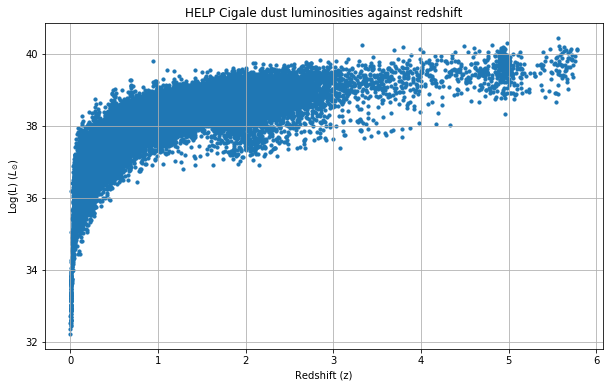

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(catalogue['redshift'],np.log10(catalogue['cigale_dustlumin']), s = 10)
plt.title('HELP Cigale dust luminosities against redshift')
plt.xlabel('Redshift (z)')
plt.ylabel('Log(L) ($L_{\odot}$)')
plt.grid()
plt.show()
plt.savefig('Luminosity_vs_redshift.png')

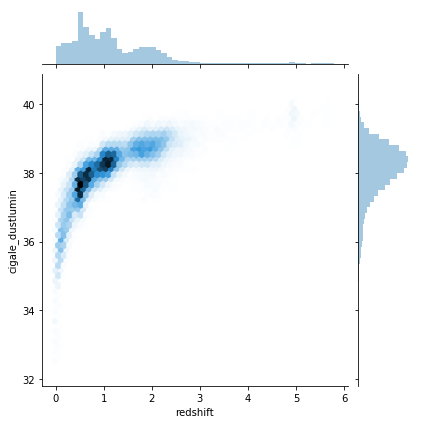

In [8]:
sns.jointplot(catalogue['redshift'], np.log10(catalogue['cigale_dustlumin']), kind="hex")#, color="#4CB391")

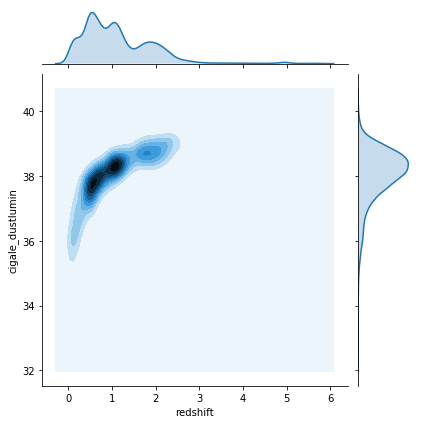

In [9]:
sns.jointplot(catalogue['redshift'], np.log10(catalogue['cigale_dustlumin']), kind="kde")#, color="#4CB391")

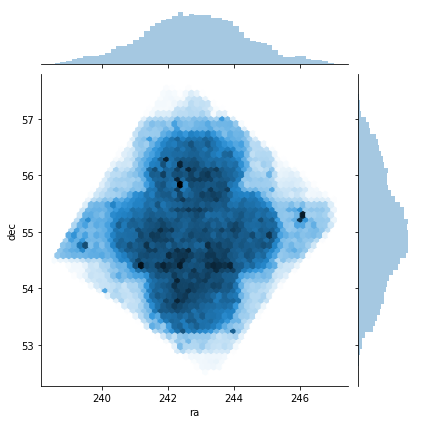

In [10]:
sns.jointplot(catalogue['ra'], catalogue['dec'], kind="hex")

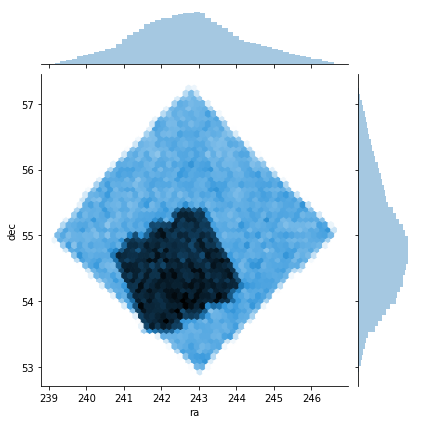

In [11]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['f_irac_i1']) ], 
              catalogue['dec'][~np.isnan(catalogue['f_irac_i1']) ], kind="hex")

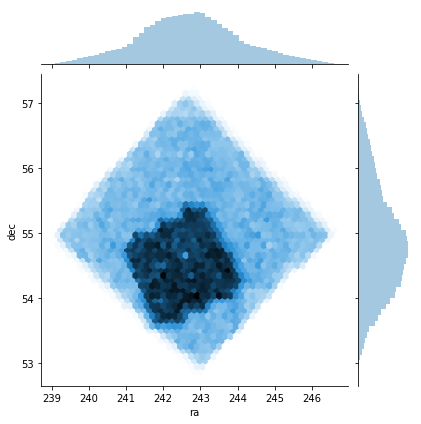

In [12]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['f_mips_24']) ], 
              catalogue['dec'][~np.isnan(catalogue['f_mips_24']) ], kind="hex")

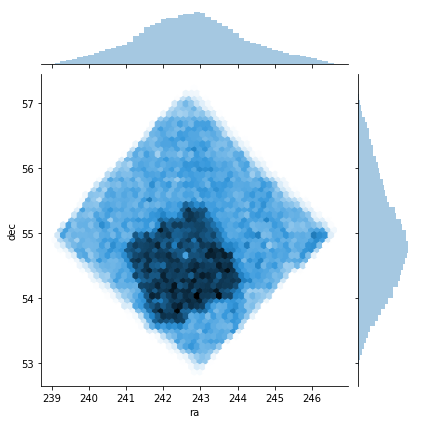

In [13]:
sns.jointplot(catalogue['ra'][catalogue['f_mips_24'] > 20. ], 
              catalogue['dec'][catalogue['f_mips_24'] > 20. ], kind="hex")

# Comparing Ldust prediction with Ldust

We also produced a prediction of Ldust for all 'good' (2+ optical and 2+ nir detections) objects with photo-z which should help us to characterise the selection

In [15]:
ldust_pred = Table.read(DMU_DIR + 'dmu28/dmu28_ELAIS-N1/data/'
                       +'ELAIS_N1_Ldust_prediction_results.fits')['id', 
                                           'bayes.dust.luminosity']
ldust_pred['bayes.dust.luminosity'].name = 'cigale_dustlumin_pred'
ldust_pred['cigale_dustlumin_pred'].fill_value = np.nan
ldust_pred = ldust_pred[~np.isnan(ldust_pred['cigale_dustlumin_pred'])]
ldust_pred['id'].name = 'help_id'
catalogue = join(catalogue, ldust_pred, join_type='left', keys='help_id')

catalogue['cigale_dustlumin_pred'].fill_value = np.nan
catalogue = catalogue.filled()

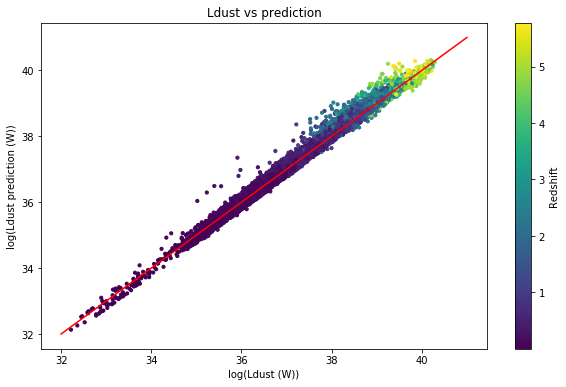

<Figure size 432x288 with 0 Axes>

In [45]:
fig, axis = plt.subplots()

im = axis.scatter(np.log10(catalogue['cigale_dustlumin']),
            np.log10(catalogue['cigale_dustlumin_pred']), 
            s = 10, alpha=1, c=catalogue['redshift'])
fig.colorbar(im, ax=axis).set_label('Redshift')
axis.plot([32., 41],[32., 41], c='r')
axis.set_title('Ldust vs prediction')
axis.set_xlabel('log(Ldust (W))')
axis.set_ylabel('log(Ldust prediction (W))')

fig.set_size_inches(10, 6)
plt.show()
plt.savefig('Ldust_vs_pred.png')

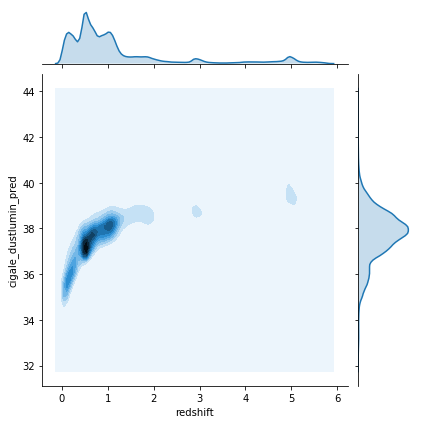

In [18]:
sns.jointplot(catalogue['redshift'], np.log10(catalogue['cigale_dustlumin_pred']), kind="kde")#, color="#4CB391")

In [49]:
"There are {} objects with a prediction, and {} with a CIGALE fit.".format(
    (~np.isnan(catalogue['cigale_dustlumin_pred'])).sum(),
    (~np.isnan(catalogue['cigale_dustlumin'])).sum())

'There are 453991 objects with a prediction, and 49986 with a CIGALE fit.'

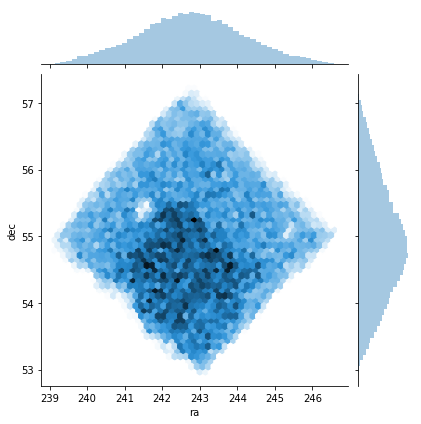

In [280]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['cigale_dustlumin'] ) ], 
              catalogue['dec'][~np.isnan(catalogue['cigale_dustlumin'] ) ], kind="hex")

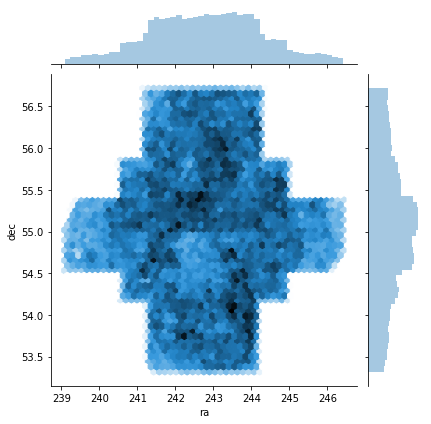

In [281]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['cigale_dustlumin_pred'] ) ], 
              catalogue['dec'][~np.isnan(catalogue['cigale_dustlumin_pred'] ) ], kind="hex")

# Simple LF as before

Without Vmax look at numbers. They are clearly too low. Will Vmax fix this?

In [40]:
(en1_moc.area/ (4* np.pi))

0.0003274306654930114

In [98]:
a= np.array([1,1.5,2,3,1.2,0.5])
b=[True, False, True, True, False, True]
print(a[b])
( u.megaparsec)**3 / np.sum(volume(1, np.minimum(a[b], 2) , cosmo) )

[ 1.   2.   3.   0.5]


<Quantity 1.2042741879081351e-08>

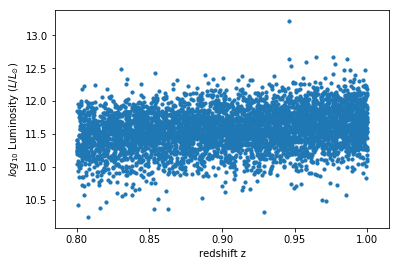

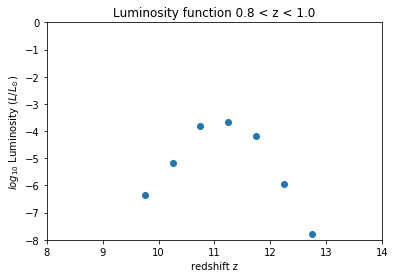

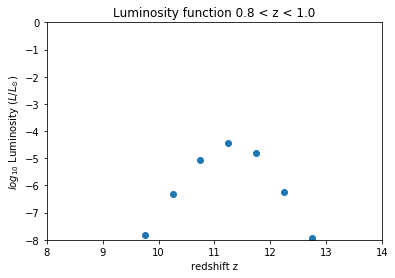

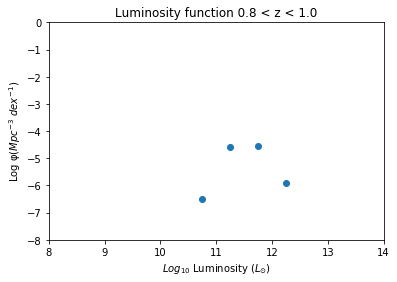

In [104]:
cosmo = FlatLambdaCDM(H0=100. , Om0 = (1-0.7))
#cosmo = Planck15

dV_z0  = cosmo.comoving_volume(0)
dV_z1  = cosmo.comoving_volume(1)
dV_z2  = cosmo.comoving_volume(2)


en1_moc = MOC(filename=DMU_DIR + 'dmu2/dmu2_field_coverages/'
                       +'ELAIS-N1_MOC.fits')
area = en1_moc.area
def volume(z1,z2,cosmo, moc =en1_moc):
    v = (cosmo.comoving_volume(z2) - cosmo.comoving_volume(z1)) * (moc.area/ (4* np.pi))
    return v

#print(volume(0.,1.,cosmo))

def plot_LF(z1,z2,Lmin,Lmax,table, 
            cosmo=cosmo, bin_width=None, l_col='cigale_dustlumin', 
            show_sample=False, show_LF = False,
            vmax=False, eff_area=False,
            moc =en1_moc):
    """Plot a crude Luminosity Function without Vmax correction applied
    
    Inputs
    ------
    bin_wdith: float
      Width of bins in log10(L)
      
    Outputs
    ------
    """
    x = table['redshift']
    y = table[l_col]
    
    
    #mask_z01 = y < Lmin
    #mask_z01 |= x > z2
    #mask_z01 |= x < z1
    mask_z01 = (  (x > z1) 
                & (x < z2))



    y = y[mask_z01]
    x = x[mask_z01]


    if show_sample:
        plt.scatter(x,np.log10(y/Lsun), s = 10)
        plt.xlabel('redshift z')
        plt.ylabel('$log_{10}$ Luminosity ($L/L_{\odot}$)')
        plt.show()

    nbins = 20 
    if bin_width is not None:
        nbins = int((np.log10(Lmax) - np.log10(Lmin) )/ bin_width)
        
    #L_min = 10**38
    #L_max = 10**39
    galaxy_sample = np.array(y)
    redshifts = np.array(x)
    has_L = ~np.isnan(galaxy_sample)
    galaxy_sample = galaxy_sample[has_L]
    redshifts = redshifts[has_L]
    #print(len(galaxy_sample), len(z_max))
    if vmax:
        z_max = table['z_max']
        z_max = z_max[mask_z01]
        z_max = z_max[has_L]
    if eff_area:
        areas = table['eff_area']
        areas = areas[mask_z01]
        areas = areas[has_L]

    galaxy_bins = Table()
    #galaxy_bins.add_column(Column(data=np.linspace(L_min, L_max, nbins), name='L_centre_values'))
    galaxy_bins.add_column(Column(data=np.logspace(np.log10(Lmin), np.log10(Lmax), num=nbins+1, base=10.0), 
                                  name='L_centre_values'))

    #dL = (L_max-L_min)/20

    galaxy_bins.add_column(Column(np.full(len(galaxy_bins), np.nan), name='dN_by_dL'))

    n=0
    if vmax:
        for gal_bin in np.arange(nbins):
            L=galaxy_bins['L_centre_values'][gal_bin]
            #print(L)
            #Get the array of zmaxes for this L bin
            mask = ((galaxy_sample > (L) ) 
                               & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1]))
            z_max_bin = z_max[mask]
            if len(z_max_bin) == 0:
                continue
            #then perform the 1/Vmax sum by taking the element wise minimum of zmax and z2
            dN_by_dL = np.sum( (( u.megaparsec)**3 ) / ( volume(z1,np.minimum(z_max_bin, z2),cosmo, moc) ) )
            
            #Test for max effect
            #dN_by_dL = np.sum( (( u.megaparsec)**3 ) / ( volume(z1,np.minimum(redshifts[mask], z2),cosmo, moc) ) )
            
            if( np.sum(volume(z1,np.minimum(z_max_bin, z2),cosmo, moc))/ 
                  np.sum(volume(z1,np.full(len(z_max_bin), z2),cosmo, moc))) < 0.5:
                continue
            #print(dN_by_dL)
            #print(np.sum(np.minimum(z_max_bin, z2) != z2)/len(z_max_bin))
        
            binwidth = galaxy_bins['L_centre_values'][gal_bin+1] - galaxy_bins['L_centre_values'][gal_bin]
            dN_by_dL= dN_by_dL / (np.log10(binwidth/Lsun))
        
            galaxy_bins['dN_by_dL'][gal_bin] = dN_by_dL
            n +=1       
        
    elif eff_area:
        for gal_bin in np.arange(nbins):
            L=galaxy_bins['L_centre_values'][gal_bin]
            #print(L)
            #areas_bin = areas[((galaxy_sample > (L) ) 
            #                   & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1]))]
            area_correct = moc.area_sq_deg/areas
            if len(area_correct) == 0:
                continue
            
            #print(len(area_correct))
            #print(len(
            #    (
            #    (galaxy_sample > (L) ) 
            #    & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1])
            #    ) ))
            dN_by_dL = np.sum(
                (
                (galaxy_sample > (L) ) 
                & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1])
                ) * area_correct)
            #print(dN_by_dL)
            dN_by_dL = dN_by_dL /( volume(z1,z2,cosmo, moc) / (( u.megaparsec)**3 ))
            #print(dN_by_dL)
            binwidth = galaxy_bins['L_centre_values'][gal_bin+1] - galaxy_bins['L_centre_values'][gal_bin]
            dN_by_dL= dN_by_dL / (np.log10(binwidth/Lsun))
        
            galaxy_bins['dN_by_dL'][gal_bin] = dN_by_dL
            n +=1
        
        
    else:
        for gal_bin in np.arange(nbins):
            L=galaxy_bins['L_centre_values'][gal_bin]
            #print(L)
            dN_by_dL = np.sum((galaxy_sample > (L) ) & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1]))
            #print(dN_by_dL)
            dN_by_dL = dN_by_dL /( volume(z1,z2,cosmo, moc) / (( u.megaparsec)**3 ))
            #print(dN_by_dL)
            binwidth = galaxy_bins['L_centre_values'][gal_bin+1] - galaxy_bins['L_centre_values'][gal_bin]
            dN_by_dL= dN_by_dL / (np.log10(binwidth/Lsun))
        
            galaxy_bins['dN_by_dL'][gal_bin] = dN_by_dL
            n +=1
    
    if show_LF:
        plt.scatter( np.log10(np.array(galaxy_bins['L_centre_values'])/Lsun), np.log10(np.array(galaxy_bins['dN_by_dL'])))
        #plt.xscale('log')
        plt.title('Luminosity function {} < z < {}'.format(z1, z2))
        plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
        plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
        plt.ylim([-8.,0.])
        plt.xlim([8.,14.])
        #plt.plot(np.array([1,2,3,4]), np.array([5,6,5,6]))
    
        #plt.savefig('Luminosity Functions')
    return galaxy_bins
    
    
plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,catalogue, bin_width=0.5, 
        show_sample=True, show_LF=True, vmax=True)
plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,catalogue, bin_width=0.5, 
        show_sample=True, show_LF=True, vmax=False)
#plt.show()


test = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=True,
              l_col='Lir')    

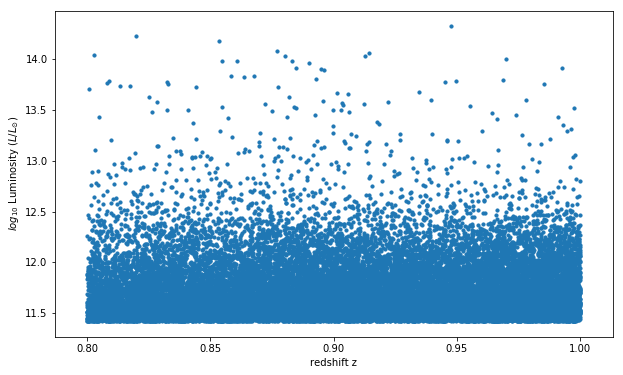

L_centre_values,dN_by_dL
float64,float64
1e+38,0.000154895246611
1.77827941004e+38,8.56264015865e-05
3.16227766017e+38,4.15192145853e-05
5.6234132519e+38,1.71154649501e-05
1e+39,nan


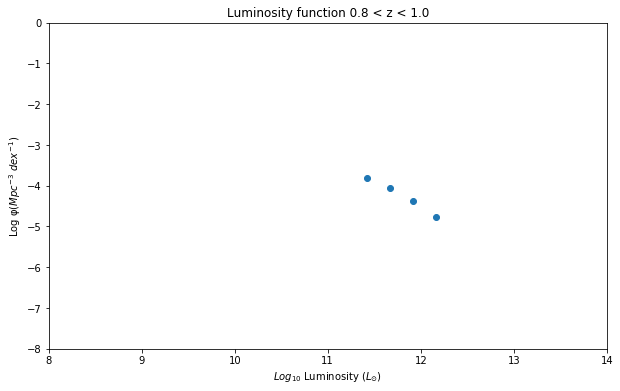

In [294]:
plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, 
        show_sample=True, show_LF=True, l_col='cigale_dustlumin_pred')

## The Grupioni total IR LF
![title](./Grupioni2013_fig6.png)

![title](./Grupioni2013_fig8.png)

In table 7 Grupioni gives modified Schechter function parameters. These will be useful for plotting comparisons to our data. The normal Schechter function is:

$$n(L) \  \mathrm{d}L = \phi^* \left(\frac{L}{L^*}\right)^\alpha \mathrm{e}^{-L/L^*} \frac{\mathrm{d}L}{L^*}$$

where $L$ is galaxy luminosity, and $L^*$ is a characteristic galaxy luminosity where the power-law form of the function cuts off. The parameter $\,\!\phi^*$ has units of number density and provides the normalization. The galaxy luminosity function may have different parameters for different populations and environments; it is not a universal function. One measurement from field galaxies is $\alpha=-1.25,\ \phi^* = 1.2 \times 10^{-2} h^3 \mathrm{Mpc}^{-3}$

The modifed Schechter function used by Gruppioni is:

$$n(L) \  \mathrm{dlog}L = \phi^* \left(\frac{L}{L^*}\right)^{(1-\alpha)} \mathrm{exp}\bigg[ - \frac{1}{2\sigma^2}\mathrm{log}^2 {(1+\frac{L}{L^*})}\bigg] \mathrm{dlog}L$$

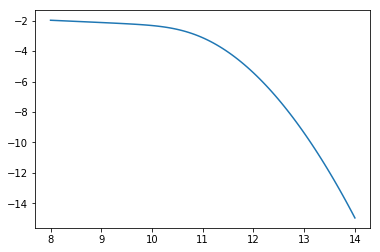

In [23]:
grup_schechter = [
    #zmin   zmax  alpha sigma L_s    L_s_err Phi_s Phi_s_err
    [0.0,   0.3,  1.15, 0.52, 10.12, 0.16,   -2.29, 0.06],
    [0.3,   0.45, 1.2,  0.5,  10.41, 0.03,   -2.31, 0.03],
    [0.45,  0.6,  1.2,  0.5,  10.55, 0.03,   -2.35, 0.05],
    [0.6,   0.8,  1.2,  0.5,  10.71, 0.03,   -2.35, 0.06],
    [0.8,   1.0,  1.2,  0.5,  10.97, 0.04,   -2.40, 0.05],
    [1.0,   1.2,  1.2,  0.5,  11.13, 0.04,   -2.43, 0.04],
    [1.2,   1.7,  1.2,  0.5,  11.37, 0.03,   -2.70, 0.04],
    [1.7,   2.0,  1.2,  0.5,  11.50, 0.03,   -3.00, 0.03],
    [2.0,   2.5,  1.2,  0.5,  11.60, 0.03,   -3.01, 0.11],
    [2.5,   3.0,  1.2,  0.5,  11.92, 0.08,   -3.27, 0.18],
    [3.0,   4.2,  1.2,  0.5,  11.90, 0.16,   -3.74, 0.30],
           ]

logL = np.linspace(8, 14, num=100)

def mod_schech(L, alpha, sigma, L_s, Phi_s):
    """Calculate \Phi(L) for an input array L, and modified Schechter params
    
    
    """
    
    phi = Phi_s * ((L/L_s)**(1-alpha)) * np.exp(- (1/(2*sigma**2)) * ((np.log10(1+(L/L_s)))**2) )
    return phi


plt.plot(logL, np.log10(mod_schech(10**logL, 
                       grup_schechter[0][2], 
                       grup_schechter[0][3], 
                       10**grup_schechter[0][4], 
                       10**grup_schechter[0][6])))

Text(0,0.5,'Log φ($Mpc^{-3}$ $dex^{-1}$)')

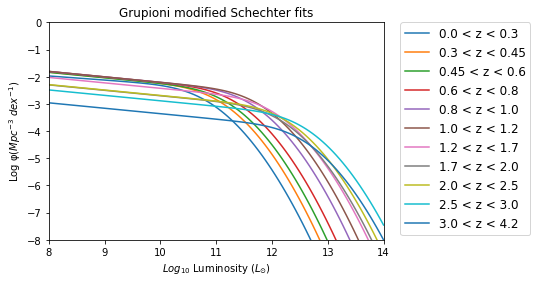

In [101]:
for dz in grup_schechter:
    #print('{} < z < {}'.format(dz[0], dz[1]))
    plt.plot(logL, np.log10(mod_schech(10**logL, 
                       dz[2], 
                       dz[3], 
                       10**dz[4], 
                       10**dz[6])),
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )

    plt.ylim([-8.,0.])
    plt.xlim([8.,14.])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
plt.title('Grupioni modified Schechter fits')
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')

In [22]:
#The data points from figure 7
#Table 6: PEP total IR luminosity function
#log(LIR/L⊙) log(Φ/Mpc−3 dex−1)
#            0.0≤z<0.3       0.3≤z<0.45      0.45≤z<0.6      0.6≤z<0.8       0.8≤z<1.0       1.0≤z<1.2       1.2≤z<1.7       1.7≤z<2.0        2.0≤z<2.5       2.5≤z<3.0    3.0≤z<4.2
pep_lf = np.array([
[8.5,  9.0,  -2.21,  0.43,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[9.0,  9.5,  -2.18,  0.09,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[9.5,  10.0, -2.28,  0.04,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[10.0, 10.5, -2.50,  0.03,   -2.37,  0.11,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[10.5, 11.0, -2.71,  0.02,   -2.64,  0.04,   -2.61,  0.08,   -2.27,  0.15,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[11.0, 11.5, -3.49,  0.06,   -3.12,  0.03,   -2.99,  0.04,   -2.89,  0.05,   -3.09,  0.08,   -2.80,  0.09,   -2.93,  0.18,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[11.5, 12.0, -4.79,  0.25,   -4.29,  0.10,   -3.89,  0.05,   -3.53,  0.03,   -3.24,  0.04,   -3.17,  0.06,   -3.29,  0.06,   -3.76,  0.13,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[12.0, 12.5, -5.27,  0.43,   -5.58,  0.43,   -5.50,  0.31,   -4.75,  0.09,   -4.23,  0.05,   -4.00,  0.03,   -3.81,  0.03,   -3.96,  0.11,   -3.53,   0.08,  -3.75,  0.21,   np.nan, np.nan],
[12.5, 13.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -5.79,  0.31,   -5.74,  0.25,   -5.18,  0.12,   -4.85,  0.05,   -4.42,  0.04,   -4.40,   0.04,  -4.15,  0.11,   -4.65,  0.14  ],
[13.0, 13.5, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -6.48,  0.31,   -6.01,  0.22,   -5.79,   0.13,  -5.11,  0.07,   -5.75,  0.13  ],
[13.5, 14.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -6.54,   0.31,  -7.18,  0.43,   np.nan, np.nan]
])

Text(0,0.5,'Log φ($Mpc^{-3}$ $dex^{-1}$)')

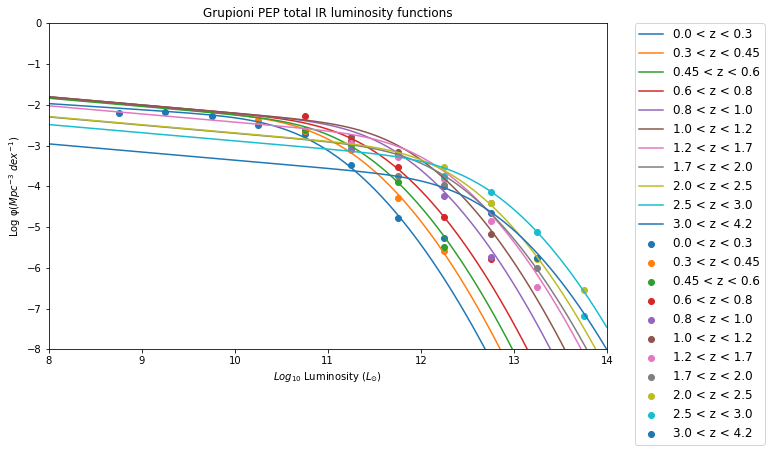

In [270]:
for n, dz in enumerate(grup_schechter):
    #print('{} < z < {}'.format(dz[0], dz[1]))

    col = 2 * n + 2
    plt.scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    plt.plot(logL, np.log10(mod_schech(10**logL, 
                       dz[2], 
                       dz[3], 
                       10**dz[4], 
                       10**dz[6])),
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )

    plt.ylim([-8.,0.])
    plt.xlim([8.,14.])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
plt.title('Grupioni PEP total IR luminosity functions')
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')

## Vmax

The simplest way to calculate Vmax is to assume selection is entirely dominated by our MIPS 20$\mu$Jy cut and compute Zmax for each galaxy ignoring K-corrections.

In [107]:
#Astropy has a function z_at_value which takes a function of z and a value and returns the z that gives that value

#from astropy.cosmology.funcs import luminosity_distance

def z_max(z_true, flux, cut=20):
    """Calculate redshift at which input flux is equal to cut"""
    lum_dist = cosmo.luminosity_distance(z_true)
    lum_dist_at_cut = np.sqrt((flux/cut)) * lum_dist
    z_max =  z_at_value( cosmo.luminosity_distance, lum_dist_at_cut)
    return z_max
    


1.91931703884


In [311]:
#Test it seems sensible
%timeit z_max(1, 100.)

6.23 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:

try:
    catalogue = Table.read('./data/vmax_product.fits')
except FileNotfoundError:
    catalogue.add_column(Column(data=np.full(len(catalogue), np.nan), name='z_max'))
    #catalogue.add_column(Column(data=np.full(len(catalogue), np.nan), name='v_max'))
    for gal in catalogue[~np.isnan(catalogue['f_mips_24']) 
                         & ~np.isnan(catalogue['redshift'])]:
        catalogue['z_max'][catalogue['help_id'] == gal['help_id']] = z_max(gal['redshift'], gal['f_mips_24']) 
    catalogue.write('./data/vmax_product.fits', overwrite=True)    

In [20]:
print('There are {} objects with f_mips_24 and {} with cigale Ldust measurements'.format(
    np.sum(~np.isnan(catalogue['f_mips_24'])),
    np.sum(~np.isnan(catalogue['cigale_dustlumin']))
))

There are 424717 objects with f_mips_24 and 49986 with cigale Ldust measurements


In [4]:
catalogue[~np.isnan(catalogue['z_max'])]

help_id,ra,dec,f_irac_i1,f_mips_24,redshift,cigale_dustlumin,cigale_dustlumin_pred,z_max
,deg,deg,uJy,uJy,,W,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,239.086706815,54.8536967355,nan,272.37057,0.6999,nan,1.6327336681e+38,2.01863232269
HELP_J155622.752+545007.875,239.094801117,54.8355208925,nan,269.6375,2.0693,nan,5.52417260594e+39,6.1567662749
HELP_J155628.233+545746.644,239.117636962,54.9629566845,nan,265.439,0.422,nan,8.0146776887e+37,1.21767002085
HELP_J155628.426+544936.570,239.118442949,54.8268248675,nan,275.15466,0.2276,nan,3.65903597235e+37,0.692350421061
HELP_J155628.601+545524.359,239.119170247,54.9234330335,nan,273.25345,0.585,nan,1.95901422789e+38,1.691835152
HELP_J155631.071+545619.623,239.12946352,54.9387842165,nan,262.12546,6.4312,nan,nan,20.0759437497
HELP_J155631.108+545024.379,239.129617199,54.8401052595,nan,258.33447,0.1287,nan,nan,0.399605824021
HELP_J155633.127+545753.634,239.138031185,54.9648984455,nan,280.96008,0.0748,nan,7.31634345982e+35,0.251445793814


Text(0.5,0,'z_max')

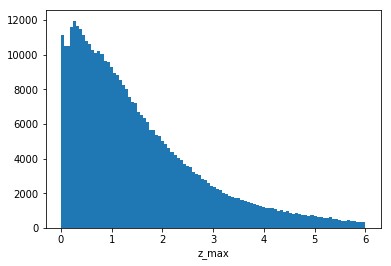

In [124]:
plt.hist(catalogue['z_max'][~np.isnan(catalogue['z_max'])], bins=100, range = (0,6))
plt.xlabel('z_max')

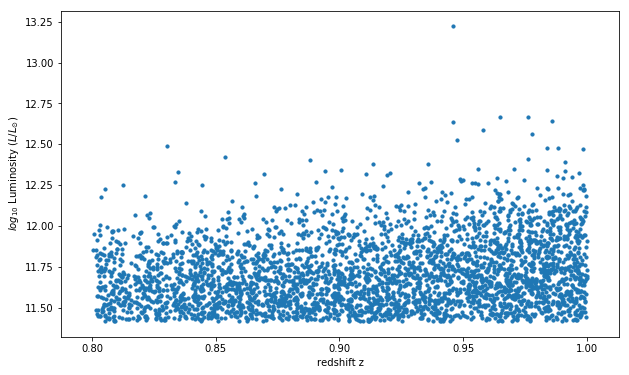

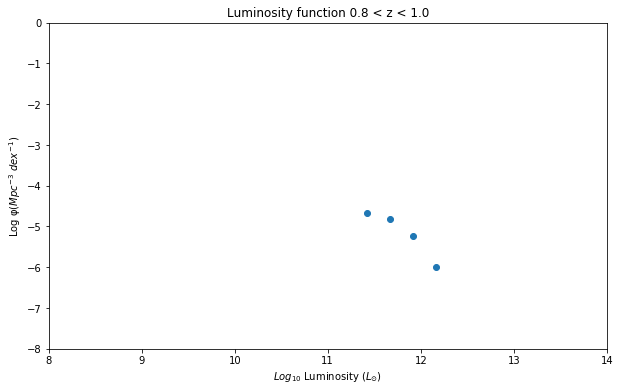

In [307]:
plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, show_sample=True, show_LF=True, vmax=True)
plt.show()

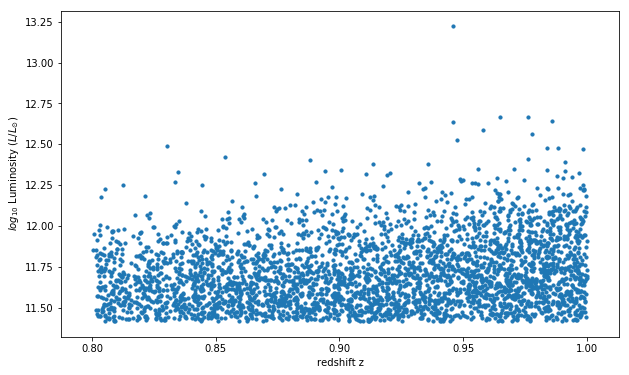

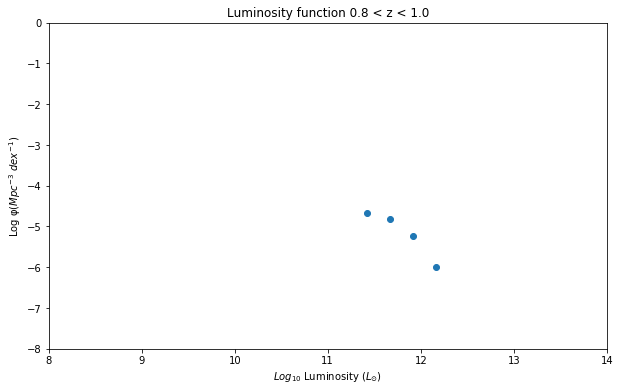

In [308]:
test = plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, show_sample=True, show_LF=True, vmax=True)

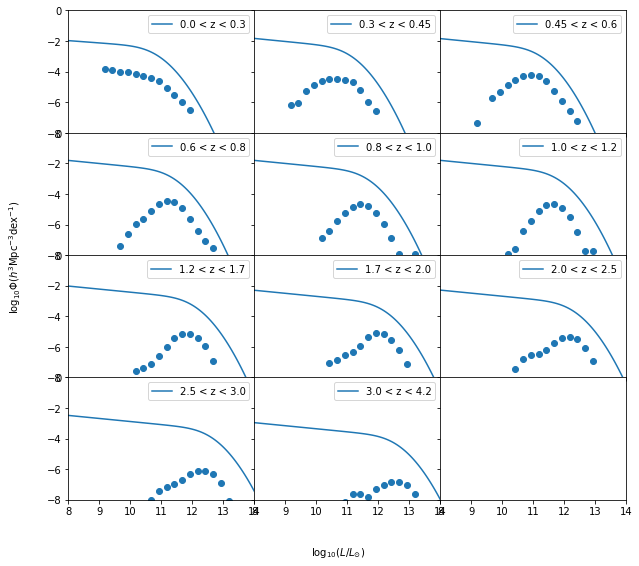

In [332]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    LF_tab = plot_LF(z_bin[0],z_bin[1],10.**35,10.**40,catalogue, bin_width=0.25, 
                     show_sample=False, show_LF=False, vmax=True, cosmo=cosmo)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), np.log10(np.array(LF_tab['dN_by_dL'])))
    

    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.0,0.])
    axes[x,y].set_xlim([8.,14.])
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()

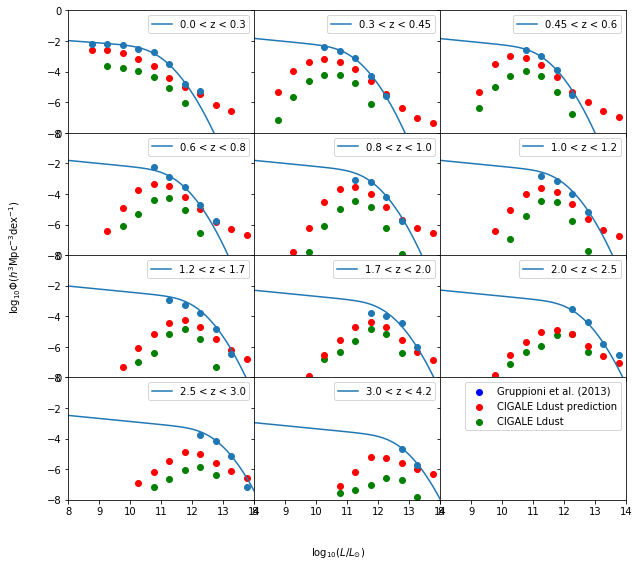

In [306]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    L1, L2 = 10**8.75 * Lsun, 10**14.25 * Lsun
    bin_width=0.5
    
    
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    #Compute LF for XID+ sample
    LF_tab = plot_LF(z_bin[0],z_bin[1],L1,L2,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=True)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab['dN_by_dL'])),
                     c='g')
    
    #Compute LF for L_dust_pred sample
    LF_tab_pred = plot_LF(z_bin[0],z_bin[1],L1,L2,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=False,
                     l_col='cigale_dustlumin_pred')
    axes[x,y].scatter( np.log10(np.array(LF_tab_pred['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab_pred['dN_by_dL'])),
                     c='r')

    #Gruppioni bins
    col = 2 * n + 2
    axes[x,y].scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            #label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    
    #Gruppioni Schechter fits
    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.,0.])
    axes[x,y].set_xlim([8.,14.])
    
if True:
    axes[3,2].scatter([-10],[-10],
            label ='Gruppioni et al. (2013)',
                      c='b'
            )
    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust prediction',
                      c='r'
            )
    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust',
                      c='g'
            )
    axes[3,2].legend()
    
    axes[3,2].set_ylim([-8.,0.])
    axes[3,2].set_xlim([8.,14.])
    
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()

In [302]:
plot_LF(0,0.3,10**9.5 * Lsun, 10**14.5 * Lsun,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=True)

L_centre_values,dN_by_dL
float64,float64
1.21020366055e+36,0.000197095137049
3.827e+36,0.000146280342006
1.21020366055e+37,7.78213808341e-05
3.827e+37,2.30027682655e-05
1.21020366055e+38,2.31904735949e-06
3.827e+38,2.02276723121e-07
1.21020366055e+39,nan
3.827e+39,nan
1.21020366055e+40,nan


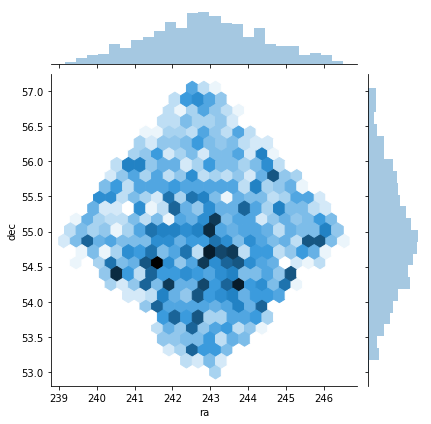

In [68]:
mask_z0p6_0p8_L_10_10p5 = ((catalogue['redshift'] < 0.8 )
                           &(catalogue['redshift'] < 0.6 )
                           &(catalogue['cigale_dustlumin'] < Lsun * 10**10.5 )
                           &(catalogue['cigale_dustlumin'] > Lsun * 10**10.0 ))
sns.jointplot(catalogue['ra'][mask_z0p6_0p8_L_10_10p5 ], 
              catalogue['dec'][mask_z0p6_0p8_L_10_10p5], kind="hex")

# COSMOS
Let us look at the COSMOS field where the prior list may have been simpler.

In [312]:
#Made a small subcat with: 
#stilts tpipe cmd='keepcols "help_id ra dec f_irac_i1 f_mips_24 redshift cigale_dustlumin"' 
#COSMOS_20180619.fits omode=out out=cut_for_lf.fits
cosmos_cat = Table.read(DMU_DIR + 'dmu32/dmu32_COSMOS/data/'
                       +'cut_for_lf.fits')['help_id',
                                           'ra', 
                                           'dec', 
                                           'f_irac_i1', 
                                           'f_mips_24',
                                           'redshift', 
                                           'cigale_dustlumin'] #ELAIS-N1_20171016.fits

In [29]:
cosmos_moc = MOC(filename=DMU_DIR + 'dmu0/dmu0_COSMOS2015/data/'
                       +'COSMOS2015-HELP_selected_20160613_MOC.fits')
cosmos_area = cosmos_moc.area

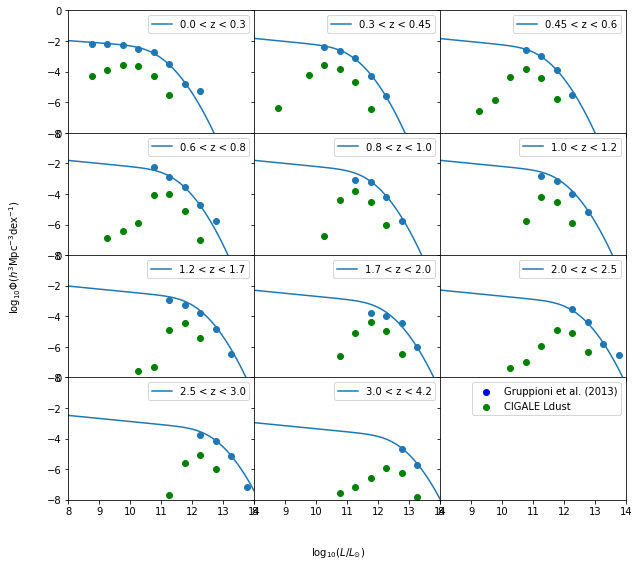

In [319]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    L1, L2 = 10**8.75 * Lsun, 10**14.25 * Lsun
    bin_width=0.5
    
    
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    #Compute LF for XID+ sample
    LF_tab = plot_LF(z_bin[0],z_bin[1],L1,L2,cosmos_cat, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=False, moc=cosmos_moc)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab['dN_by_dL'])),
                     c='g')
    

    #Gruppioni bins
    col = 2 * n + 2
    axes[x,y].scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            #label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    
    #Gruppioni Schechter fits
    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.,0.])
    axes[x,y].set_xlim([8.,14.])
    
if True:
    axes[3,2].scatter([-10],[-10],
            label ='Gruppioni et al. (2013)',
                      c='b'
            )

    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust',
                      c='g'
            )
    axes[3,2].legend()
    
    axes[3,2].set_ylim([-8.,0.])
    axes[3,2].set_xlim([8.,14.])
    
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()

In [5]:
grup_cat = Table.read('./data/cosmos_160um_0.8-1_pos24.fits')

In [12]:
grup_cat['z'].name = 'redshift'
grup_cat.add_column(Column(data=np.full(len(grup_cat), np.nan), name='Lir', dtype='float64'))
grup_cat['Lir'] = Lsun * 10 ** grup_cat['LogLir']

In [19]:
grup_cat

ID,redshift,f_FUV,f_NUV f,_B,f_g,f_V,f_R,f_i,f_z,f_J,f_K,f_3.6,f_4.5,f_5.8,f_8.0,f_24,f_100,f_160,f_250,f_350,f_500,LogLir,eff_area,id24,ra24,dec24,Lir
int16,float32,float32,float32,float32,float32,bytes10,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,int32,int32,int32,int32,int32,float64,float32,int32,float64,float64,float64
41,0.92,0.0,0.3148,0.3474,0.52,1.175,2.777,9.179,18.5,43.17,136.4,167,134.6,113.7,109.8,727.1,49800,106300,74470,47600,38190,12.5,2.04,38696,149.933008,2.558845,1.21051988831e+39
56,0.95,1.876,4.479,4.952,5.546,6.564,8.076,15.56,21.26,38.83,61.89,86.46,84.41,96.74,241.0,1727.0,77480,97630,61150,29950,0,12.6400003433,2.04,50319,150.769797,1.564333,1.67098392678e+39
62,0.84,0.4898,1.692,2.017,2.471,4.521,7.77,24.77,43.29,74.61,192.8,235.5,313.9,508.2,1471.0,4639.0,63680,95320,70400,41920,12820,12.4799995422,2.04,51496,150.722208,2.039591,1.15603630006e+39
114,0.9,0.0,0.5776,0.62,0.7635,1.097,1.738,4.223,6.415,12.31,31.45,59.43,48.39,52.24,56.75,841.8,48800,74470,52380,30390,0,12.3999996185,2.04,51857,150.149444,2.59561,9.61549281389e+38
150,0.92,0.0,0.1393,0.153,0.1975,0.326,0.6989,2.158,4.007,9.854,38.19,78.85,65.22,74.68,93.76,635.0,39410,67670,49290,38980,18230,12.3999996185,2.04,51033,150.492919,2.584734,9.61549281389e+38
201,0.86,0.08091,0.2669,0.3119,0.4014,0.9129,1.738,5.927,10.53,21.4,60.87,88.31,68.17,57.28,65.34,587.8,31100,60420,54150,37770,18100,12.1800003052,2.04,32860,149.716677,2.705699,5.79391653036e+38
202,0.95,0.5277,2.592,2.742,3.082,3.688,4.639,8.766,12.16,21.98,38.73,60.93,52.34,61.26,104.6,735.9,41110,60310,39990,22000,0,12.3599996567,2.04,13611,149.771126,1.990267,8.76943444229e+38
206,0.92,0.0,0.3221,0.4313,0.5375,0.9462,1.795,5.385,9.854,24.3,76.21,108,92.3,76.63,75.37,592.1,18400,59590,65520,53600,27060,12.2700004578,2.04,11923,150.487236,1.830812,7.12807707242e+38
240,0.89,0.0,0.4361,0.51,0.5302,0.8511,1.363,3.545,5.649,11.87,40.36,70.15,60.09,60.53,82.26,562.9,31390,56810,40890,27800,19860,12.2299995422,2.04,47281,150.15915,2.191273,6.50086984944e+38


(array([  12.,    7.,    9.,    9.,   81.,   80.,   98.,   47.,   36.,  105.]),
 array([ 0.44999999,  0.60899999,  0.76799998,  0.92699998,  1.08599998,
         1.24499997,  1.40399997,  1.56299997,  1.72199997,  1.88099996,
         2.03999996]),
 <a list of 10 Patch objects>)

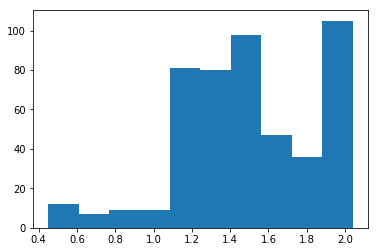

In [32]:
plt.hist(grup_cat['eff_area'])

(array([ 51.,  59.,  75.,  54.,  20.,  36.,  73.,  45.,  32.,  39.]),
 array([ 0.80000001,  0.81900001,  0.83800001,  0.85700001,  0.87600001,
         0.89500001,  0.91400001,  0.93300001,  0.95200001,  0.97100001,
         0.99000001]),
 <a list of 10 Patch objects>)

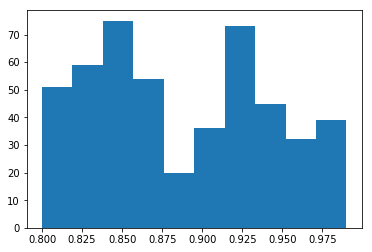

In [33]:
plt.hist(grup_cat['redshift'])

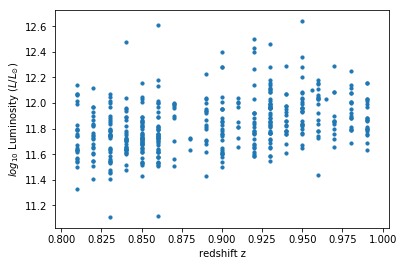

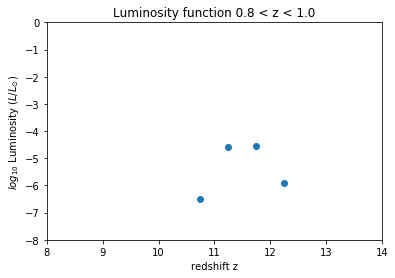

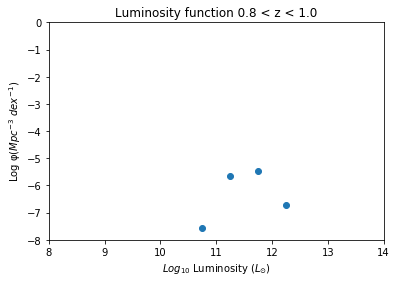

In [64]:
test = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=True,
              l_col='Lir')

test2 = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=False,
              l_col='Lir')

(8.0, 14.0)

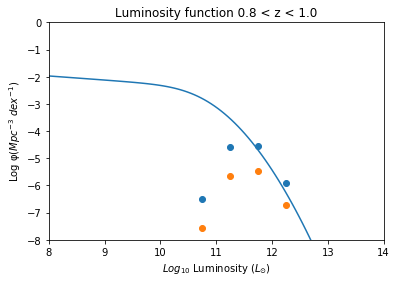

In [65]:
plt.scatter( np.log10(np.array(test['L_centre_values'])/Lsun), np.log10(np.array(test['dN_by_dL'])))
        #plt.xscale('log')
plt.scatter( np.log10(np.array(test2['L_centre_values'])/Lsun), np.log10(np.array(test2['dN_by_dL'])))

plt.plot(logL, np.log10(mod_schech(10**logL, 
                       grup_schechter[0][2], 
                       grup_schechter[0][3], 
                       10**grup_schechter[0][4], 
                       10**grup_schechter[0][6])))
plt.title('Luminosity function {} < z < {}'.format(0.8, 1.0))
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
plt.ylim([-8.,0.])
plt.xlim([8.,14.])

It seems as though the effective area which presumably is a representation of the Vmax method brings their number counts up. Lets lookt at the area distribution of our points and the number dropoffs at each selection stage.

In [69]:
z_test = np.linspace(0.8, 1., num=100)

In [71]:
v_test = volume(0.8,z_test,cosmo)

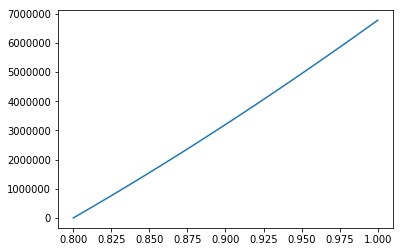

In [72]:
plt.plot(z_test, v_test)

In [73]:
z_test2 = np.linspace(0, 4., num=100)

In [74]:
v_test2 = volume(0.8,z_test2,cosmo)

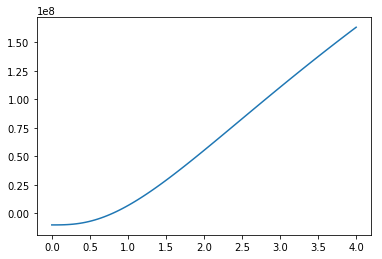

In [75]:
plt.plot(z_test2, v_test2)

(array([ 226.,  168.,   58.,    7.,   10.,    0.,    3.,    3.,    8.,    1.]),
 array([ 1.0229212 ,  1.38435341,  1.74578562,  2.10721782,  2.46865003,
         2.83008224,  3.19151444,  3.55294665,  3.91437886,  4.27581106,
         4.63724327]),
 <a list of 10 Patch objects>)

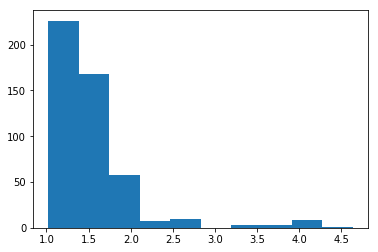

In [77]:
plt.hist(cosmos_moc.area_sq_deg/grup_cat['eff_area'])

In [78]:
np.mean(cosmos_moc.area_sq_deg/grup_cat['eff_area'])

1.5101999

In [80]:
np.sum(np.array([True, True, False, False]) * np.array([1,4,7,8]) )

5